## 0.0 Intoduction

This notebook aims to answer the following research question:

**“Which hashtags have been most frequently used on Mastodon over the given time frame, and how has their usage varied over time?”**

We will approach this question by going through the following steps:

1. Import libraries and configure the Mastodon access token.  
2. Fetch trending hashtag data from the Mastodon API and store it.  
3. Prepare the data for analysis.  
4. Analyze hashtag frequency and trends, including visualizations.  
5. Draw conclusions based on the findings.


## 1.0 Import libraries & prerequsites

In [1]:
pip install --upgrade Mastodon.py

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install wordcloud

In [3]:
with open('../token.txt', 'r') as file:
    ACCESS_TOKEN = file.read().strip()

In [4]:
from mastodon import Mastodon
import pandas as pd
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [5]:
mastodon = Mastodon(
    access_token=ACCESS_TOKEN,
    api_base_url='https://mastodon.social')


### 1.1 Testing connection 

In [6]:
me = mastodon.account_verify_credentials()
print(me['username'], "is authenticated")


Lia_067 is authenticated


## 2.0 Collect data

### 2.1 define time window

In [7]:
# end_date = datetime.utcnow()
# start_date = end_date - timedelta(days=30)
# print("Collecting from", start_date, "to", end_date)

### 2.2 Fetching tags

In [8]:
trending_tags = mastodon.trending_tags(limit=20)
for t in trending_tags:
    print(t['name'], t['history'][0]['uses'], "uses today")


remodelasongorpoem 496 uses today
mashupbandsandreligion 6 uses today
リアの数だけ好きな曲を言え見た人も 47 uses today
steammachine 90 uses today
valve 103 uses today
MeerMittwoch 3 uses today
steamframe 39 uses today
aurora 82 uses today
NorthernLights 40 uses today
あいしてるの予測変換晒そう 3 uses today
過去一しょうもない事自慢した奴が優勝 33 uses today
ThursdayFiveList 23 uses today
AuroraBorealis 34 uses today
むいちゃんを揃えよう 27 uses today
〇〇があるならもあるよね 32 uses today
ThrowbackThursday 26 uses today
musiquinta 28 uses today
steamcontroller 21 uses today
doorsday 27 uses today
名作のタイトルを組み合わせて壮大にする 29 uses today


In [9]:
for t in trending_tags:
    print(t['name'], t['history'])

remodelasongorpoem [TagHistory([('day', datetime.datetime(2025, 11, 13, 0, 0, tzinfo=datetime.timezone.utc)), ('uses', '496'), ('accounts', '113')]), TagHistory([('day', datetime.datetime(2025, 11, 12, 0, 0, tzinfo=datetime.timezone.utc)), ('uses', '0'), ('accounts', '0')]), TagHistory([('day', datetime.datetime(2025, 11, 11, 0, 0, tzinfo=datetime.timezone.utc)), ('uses', '0'), ('accounts', '0')]), TagHistory([('day', datetime.datetime(2025, 11, 10, 0, 0, tzinfo=datetime.timezone.utc)), ('uses', '0'), ('accounts', '0')]), TagHistory([('day', datetime.datetime(2025, 11, 9, 0, 0, tzinfo=datetime.timezone.utc)), ('uses', '0'), ('accounts', '0')]), TagHistory([('day', datetime.datetime(2025, 11, 8, 0, 0, tzinfo=datetime.timezone.utc)), ('uses', '0'), ('accounts', '0')]), TagHistory([('day', datetime.datetime(2025, 11, 7, 0, 0, tzinfo=datetime.timezone.utc)), ('uses', '0'), ('accounts', '0')])]
mashupbandsandreligion [TagHistory([('day', datetime.datetime(2025, 11, 13, 0, 0, tzinfo=datetime

In [10]:
data = []
for tag in trending_tags:
    tag_name = tag['name']
    for entry in tag['history']:
        data.append({
            'hashtag': tag_name,
            'date': entry['day'],
            'uses': entry['uses']
        })

### 2.3 Create DataFrame

In [11]:
df_trending = pd.DataFrame(data)
df_trending['date'] = pd.to_datetime(df_trending['date'])
df_trending = df_trending.sort_values(['date']).reset_index(drop=True)

In [12]:
df_trending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   hashtag  140 non-null    object             
 1   date     140 non-null    datetime64[ns, UTC]
 2   uses     140 non-null    object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 3.4+ KB


In [13]:
df_trending.head()

,hashtag,date,uses
0,あいしてるの予測変換晒そう,2025-11-07 00:00:00+00:00,0
1,valve,2025-11-07 00:00:00+00:00,4
2,MeerMittwoch,2025-11-07 00:00:00+00:00,2
3,steamframe,2025-11-07 00:00:00+00:00,0
4,aurora,2025-11-07 00:00:00+00:00,12


In [14]:
df_trending.tail()

,hashtag,date,uses
135,mashupbandsandreligion,2025-11-13 00:00:00+00:00,6
136,むいちゃんを揃えよう,2025-11-13 00:00:00+00:00,27
137,〇〇があるならもあるよね,2025-11-13 00:00:00+00:00,32
138,doorsday,2025-11-13 00:00:00+00:00,27
139,remodelasongorpoem,2025-11-13 00:00:00+00:00,496


### 2.4 Convert into csv

In [15]:
df_trending.to_csv("../data/mastodon_hashtags_raw.csv", index=False, encoding='utf-8')
print("Data saved as mastodon_hashtags_raw.csv")

Data saved as mastodon_hashtags_raw.csv


## 3.0 Data Prepration

In [16]:
df_trending = pd.read_csv("../data/mastodon_hashtags_raw.csv")

### 3.1 Feature Engeneering

In [17]:
df_trending['date'] = pd.to_datetime(
    df_trending['date'],
    errors='coerce',
    infer_datetime_format=True
)

C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\3786535951.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_trending['date'] = pd.to_datetime(


In [18]:
df_trending['year'] = df_trending['date'].dt.year
df_trending['month'] = df_trending['date'].dt.month
df_trending['day'] = df_trending['date'].dt.day
df_trending['weekday'] = df_trending['date'].dt.day_name()
df_trending.drop(columns=['date'], inplace=True)

df_trending.head()

,hashtag,uses,year,month,day,weekday
0,あいしてるの予測変換晒そう,0,2025,11,7,Friday
1,valve,4,2025,11,7,Friday
2,MeerMittwoch,2,2025,11,7,Friday
3,steamframe,0,2025,11,7,Friday
4,aurora,12,2025,11,7,Friday


### 3.2 Data Investgeation

In [19]:
df_trending.uses.describe()

count    140.000000
mean      25.928571
std       93.623588
min        0.000000
25%        0.000000
50%        0.000000
75%        6.000000
max      795.000000
Name: uses, dtype: float64

In [20]:
df_trending['uses'].replace(0, 1, inplace=True)

C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\4155499921.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_trending['uses'].replace(0, 1, inplace=True)


## 4.0 Data Analysis

### 4.1 frequency analysis

In [21]:
freq = df_trending.groupby('hashtag')['uses'].sum().sort_values(ascending=False)
freq


hashtag
mashupbandsandreligion    806
aurora                    648
remodelasongorpoem        502
valve                     302
NorthernLights            257
steammachine              232
AuroraBorealis            182
steamframe                134
MeerMittwoch              106
あいしてるの予測変換晒そう              82
steamcontroller            74
musiquinta                 63
リアの数だけ好きな曲を言え見た人も          58
ThrowbackThursday          44
過去一しょうもない事自慢した奴が優勝         39
doorsday                   39
〇〇があるならもあるよね               38
名作のタイトルを組み合わせて壮大にする        35
むいちゃんを揃えよう                 33
ThursdayFiveList           31
Name: uses, dtype: int64

C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\3748064862.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.index, y=freq.values, palette="viridis")
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\3748064862.py:7: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\3748064862.py:7: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\3748064862.py:7: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\3748064862.py:7: UserWarning: Glyph 12390 (\N{HIRAGANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\User

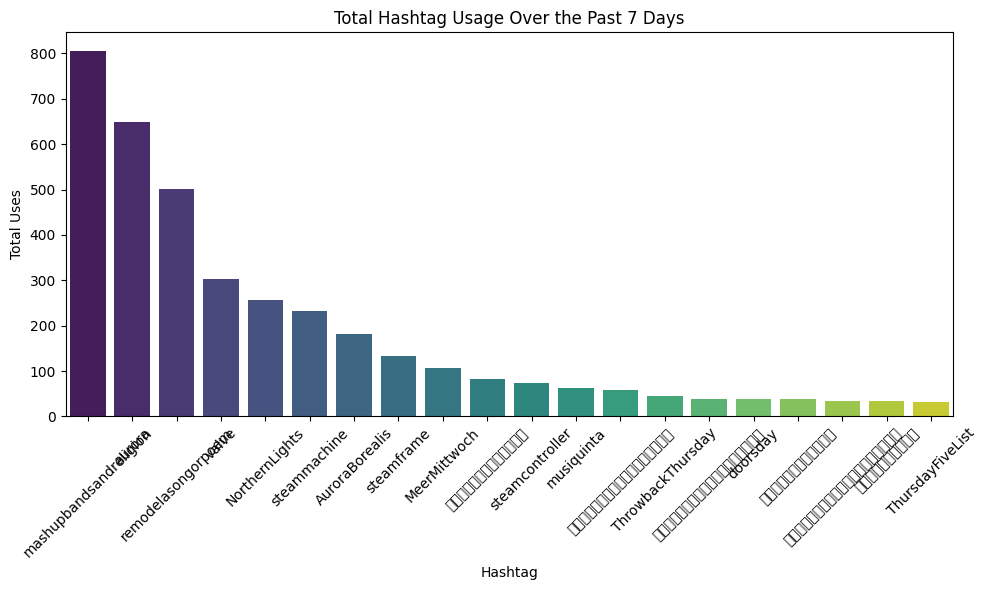

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(x=freq.index, y=freq.values, palette="viridis")
plt.title("Total Hashtag Usage Over the Past 7 Days")
plt.xlabel("Hashtag")
plt.ylabel("Total Uses")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.2 daily usage

In [23]:
df_trending['date'] = pd.to_datetime(df_trending[['year','month','day']])
daily_usage = df_trending.groupby(['date','hashtag'])['uses'].sum().reset_index()
daily_usage


,date,hashtag,uses
0,2025-11-07,AuroraBorealis,2
1,2025-11-07,MeerMittwoch,2
2,2025-11-07,NorthernLights,7
3,2025-11-07,ThrowbackThursday,12
4,2025-11-07,ThursdayFiveList,3
...,...,...,...
135,2025-11-13,あいしてるの予測変換晒そう,3
136,2025-11-13,むいちゃんを揃えよう,27
137,2025-11-13,リアの数だけ好きな曲を言え見た人も,47
138,2025-11-13,名作のタイトルを組み合わせて壮大にする,29


C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\1617451613.py:7: UserWarning: Glyph 12295 (\N{IDEOGRAPHIC NUMBER ZERO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\1617451613.py:7: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\1617451613.py:7: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\1617451613.py:7: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\1617451613.py:7: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Meeso\AppData\Local\Temp\ipykernel_3788\1617451613.py:7: UserWarning: Glyph 12425 (\N{HIRAGANA LETTER RA}) missing from font(s) Deja

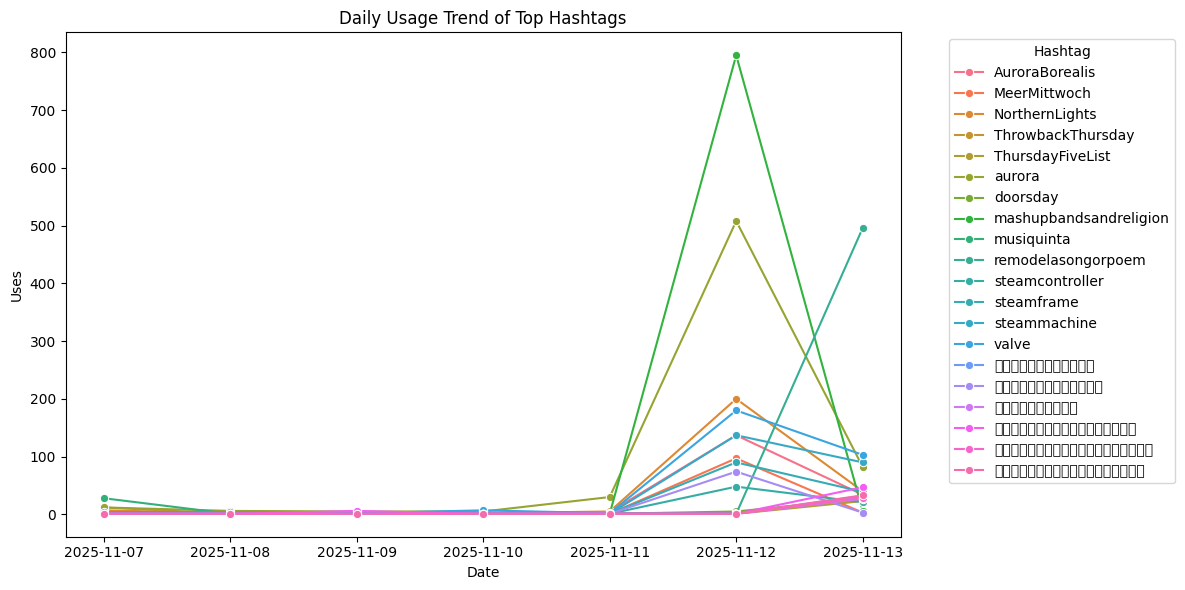

In [24]:
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_usage, x='date', y='uses', hue='hashtag', marker='o')
plt.title("Daily Usage Trend of Top Hashtags")
plt.xlabel("Date")
plt.ylabel("Uses")
plt.legend(title='Hashtag', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 4.3 Specific topic over the past 7 days

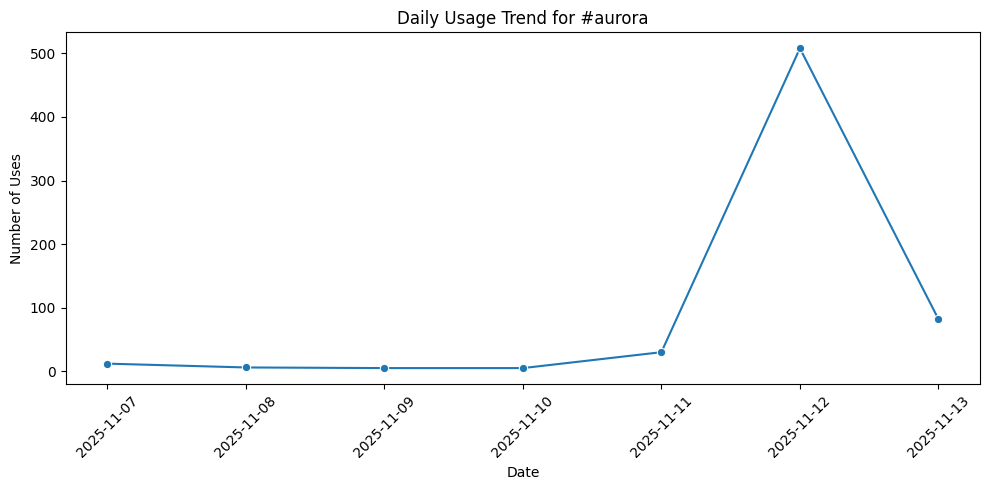

In [25]:
topic = "aurora"

df_trending['date'] = pd.to_datetime(df_trending[['year','month','day']])

df_topic = df_trending[df_trending['hashtag'] == topic]

daily_topic_usage = df_topic.groupby('date')['uses'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_topic_usage, x='date', y='uses', marker='o')
plt.title(f"Daily Usage Trend for #{topic}")
plt.xlabel("Date")
plt.ylabel("Number of Uses")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4.5 Today`s hashtags

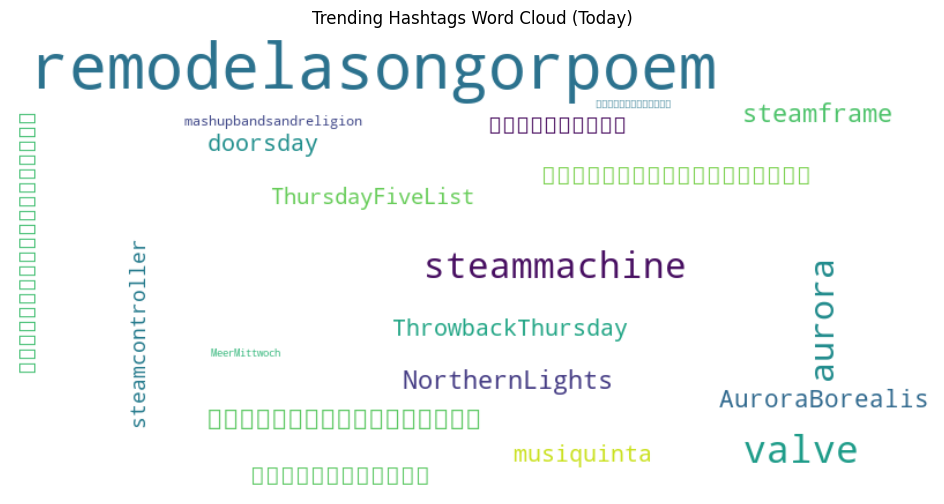

In [26]:
trending_tags = mastodon.trending_tags(limit=20)

hashtag_freq = {t['name']: int(t['history'][0]['uses']) for t in trending_tags}

hashtag_freq = {k: v for k, v in hashtag_freq.items() if v > 0}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtag_freq)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Trending Hashtags Word Cloud (Today)")
plt.show()


## 5.0 Conclusion

## Conclusion

Based on the analysis of trending hashtags on Mastodon, we identified the most frequently used topics and observed how their usage varied over the recent period. The visualization and word cloud highlighted both global trends and language-specific trends, including Japanese hashtags, providing a clear view of user interests and activity spikes.  

Given the **dynamic and rapidly changing nature of social media content**, a static analysis captures only a snapshot in time. To better monitor trends in real time, an **interactive Streamlit app** would be ideal, allowing users to explore hashtag usage dynamically, filter by topic or date, and visualize evolving patterns as they happen. This approach would make the analysis more flexible, up-to-date, and actionable.
